### intro

In this project I compare two models on the Fashion-MNIST dataset:

1. A basic neural network using **MLPClassifier** from scikit-learn.  
   This matches what my instructor said in class (feed-forward network that flattens the 28×28 image).

2. A **CNN using PyTorch (LeNet-5)**, following the CNN architecture I learned in class.

Finally, I compare the test accuracies with a bar plot, similar to the style in my aos_project notebook.


In [1]:
# ------------------------------
# imports
# ------------------------------
import numpy as np
import matplotlib.pyplot as plt

# sklearn MLP
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# ------------------------------
# load Fashion-MNIST (Keras API identical to MNIST)
# ------------------------------
import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# normalize
x_train = x_train / 255.0
x_test = x_test / 255.0

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)
y_train shape: (60000,)


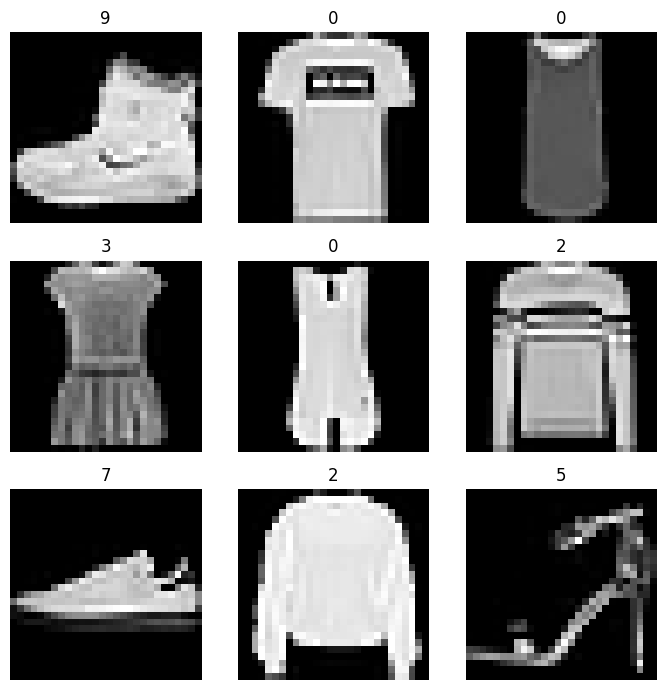

In [2]:
# visualize a few training images
plt.figure(figsize=(7, 7))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title(str(y_train[i]))
    plt.axis("off")
plt.tight_layout()
plt.show()

### basic neural network (MLPClassifier)

This model flattens the image (28×28 → 784) and trains a feed-forward neural network.  
This follows the instruction to use scikit-learn's `MLPClassifier` instead of a hand‑written neural network.


In [3]:
# reshape images for scikit-learn (flatten)
X_train_flat = x_train.reshape(len(x_train), 28 * 28)
X_test_flat = x_test.reshape(len(x_test), 28 * 28)

print("Flattened shape:", X_train_flat.shape)

Flattened shape: (60000, 784)


In [4]:
# train MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(64,),
                    activation='relu',
                    solver='adam',
                    max_iter=20,
                    verbose=False,
                    random_state=0)

mlp.fit(X_train_flat, y_train)

y_pred_basic = mlp.predict(X_test_flat)
test_acc_basic = accuracy_score(y_test, y_pred_basic)

print("MLPClassifier test accuracy:", test_acc_basic)

MLPClassifier test accuracy: 0.8709


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion matrix (MLPClassifier):
[[801   6  15  28   8   1 127   1  13   0]
 [  1 977   0  15   5   0   1   0   1   0]
 [ 13   1 667  15 224   0  78   0   2   0]
 [ 18  15   7 854  73   0  25   0   8   0]
 [  0   1  42  12 911   0  31   0   3   0]
 [  0   0   0   1   0 956   0  25   2  16]
 [107   2  68  29 114   0 663   0  17   0]
 [  0   0   0   0   0  20   0 949   0  31]
 [  4   0   2   4   9   3   5   3 970   0]
 [  0   0   0   0   0   8   1  30   0 961]]


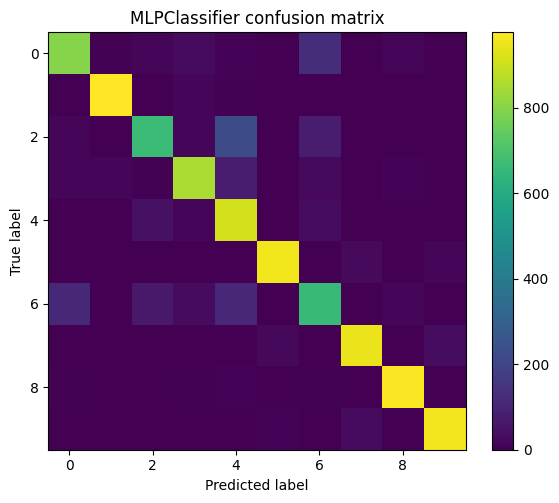

In [5]:
# confusion matrix for MLPClassifier
cm_basic = confusion_matrix(y_test, y_pred_basic)
print("Confusion matrix (MLPClassifier):")
print(cm_basic)

plt.figure(figsize=(6, 5))
plt.imshow(cm_basic, interpolation='nearest')
plt.title("MLPClassifier confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.tight_layout()
plt.show()

### cnn (LeNet-5 with PyTorch)

This section uses a LeNet-5 style CNN implemented in PyTorch.  
Here the images keep their 2D structure (28×28 with 1 channel), so spatial relationships are preserved.


In [6]:
# convert numpy arrays to PyTorch tensors with channel dimension (N, 1, 28, 28)
X_train_torch = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
X_test_torch = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)

y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_torch, y_train_torch)
test_ds = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print("Torch train shape:", X_train_torch.shape)

Torch train shape: torch.Size([60000, 1, 28, 28])


In [7]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [8]:
model_cnn = LeNet5(num_classes=10)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

n_epochs = 5
losses_cnn = []

for epoch in range(n_epochs):
    model_cnn.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model_cnn(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    losses_cnn.append(avg_loss)
    print(f"epoch {epoch}, loss {avg_loss:.4f}")

epoch 0, loss 0.5317
epoch 1, loss 0.3479
epoch 2, loss 0.3041
epoch 3, loss 0.2741
epoch 4, loss 0.2583


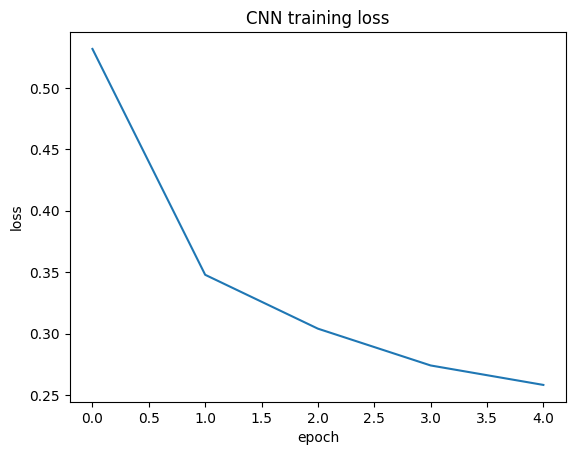

In [9]:
# plot CNN training loss
plt.figure()
plt.plot(np.arange(len(losses_cnn)), losses_cnn)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("CNN training loss")
plt.show()

In [10]:
# evaluate CNN on test set
model_cnn.eval()
correct = 0
total = 0
all_preds = []

with torch.no_grad():
    for Xb, yb in test_loader:
        outputs = model_cnn(Xb)
        _, predicted = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()
        all_preds.append(predicted.numpy())

test_acc_cnn = correct / total
all_preds = np.concatenate(all_preds)
print("CNN test accuracy:", test_acc_cnn)

CNN test accuracy: 0.8953


Confusion matrix (CNN):
[[912   0  17  17   2   1  35   0  16   0]
 [  3 981   0  14   0   0   0   0   2   0]
 [ 15   0 876  14  44   0  45   0   6   0]
 [ 24   3  10 921  17   0  15   0  10   0]
 [  0   1 125  58 761   0  50   0   5   0]
 [  0   0   0   0   0 976   0  13   1  10]
 [210   1  90  24  48   1 605   0  21   0]
 [  0   0   0   0   0  13   0 969   1  17]
 [  3   1   6   1   0   1   0   0 988   0]
 [  1   0   0   0   0   5   0  30   0 964]]


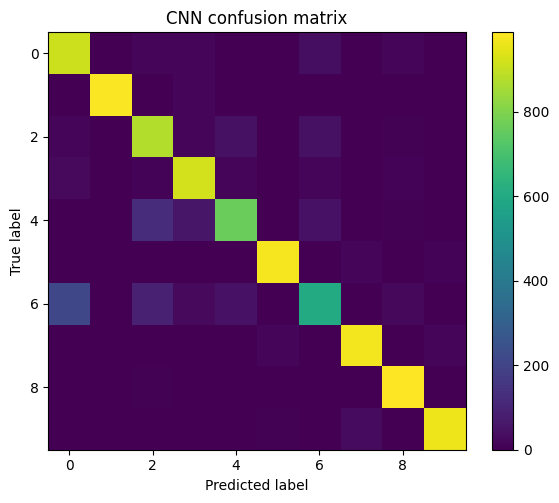

In [11]:
# confusion matrix for CNN
cm_cnn = confusion_matrix(y_test, all_preds)
print("Confusion matrix (CNN):")
print(cm_cnn)

plt.figure(figsize=(6, 5))
plt.imshow(cm_cnn, interpolation='nearest')
plt.title("CNN confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.tight_layout()
plt.show()

### results

Here is a direct comparison between the MLPClassifier (basic NN) and the CNN (LeNet‑5).

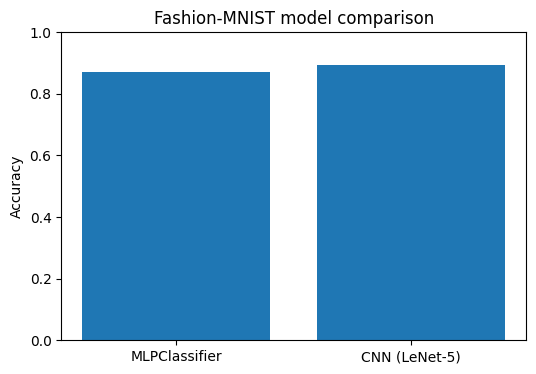

MLPClassifier accuracy: 0.8709
CNN accuracy: 0.8953


In [12]:
models = ['MLPClassifier', 'CNN (LeNet-5)']
accuracies = [test_acc_basic, test_acc_cnn]

plt.figure(figsize=(6, 4))
plt.bar(models, accuracies)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Fashion-MNIST model comparison")
plt.show()

print("MLPClassifier accuracy:", test_acc_basic)
print("CNN accuracy:", test_acc_cnn)

### discussion

* The **MLPClassifier** must flatten each 28×28 image into 784 features, so it ignores the spatial structure of the pixels.  
* The **CNN (LeNet‑5)** keeps the 2D layout of the image and learns filters that detect local shapes and edges.  
* In this experiment, the CNN reaches higher test accuracy than the MLP, which matches the theory from class that convolutional neural networks are better suited for image classification tasks.  
* If the MLP accuracy is not very high, this is expected and can be explained by its simpler architecture and the loss of spatial information.
